# Speedrunning Model Training
(includes `pytorch-lightning`!!)  

In your 2-hour-ish allocated time for training your model, chances are its going to be difficult to train a model quickly enough, fast enough. So, how can we squeeze the most time out of what we have?  

This is a list of techniques to use, one by one, to see how much we can improve times by. As a starter, we will train ResNet18 from scratch on CIFAR-10, for 10 epochs, and see how long 10 epochs takes.

In [1]:
import torch
import torch.nn as nn
import torchvision

In [4]:
import torchvision.transforms as transforms

In [3]:
train_transforms = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.AutoAugment(transforms.AutoAugmentPolicy.CIFAR10),
    transforms.ToTensor(),
    transforms.Normalize([0.48, 0.44, 0.40], [0.22, 0.22, 0.22])
])
test_transforms = transforms.Compose([
    transforms.Resize((32, 32)), 
    transforms.ToTensor(),
    transforms.Normalize([0.48, 0.44, 0.40], [0.22, 0.22, 0.22])
])

train_ds = torchvision.datasets.CIFAR10(root="data", train=True, download=True, transform=train_transforms)
test_ds = torchvision.datasets.CIFAR10(root="data", train=False, download=True, transform=test_transforms)

100%|██████████| 170M/170M [00:02<00:00, 80.7MB/s] 


Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


In [4]:
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=32, shuffle=False, num_workers=2)

In [2]:
from torchvision.models import resnet18

In [6]:
model = resnet18()
model # hm we gotta replace the fc

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

I'm gonna use PyTorch Lightning because, well, I'm a lazy person and its made for lazy people like me. Yay!!

In [3]:
import pytorch_lightning as pl
import torchmetrics

In [4]:
class LResNet(pl.LightningModule):
    def __init__(self, resnet_cls, lr):
        super().__init__()
        self.resnet = resnet_cls()
        self.resnet.fc = nn.Linear(512, 10)
        self.lr = lr

        self.accuracy = torchmetrics.Accuracy("multiclass", num_classes=10)

    def training_step(self, batch, batch_idx):
        X, y = batch
        y_pred = self.resnet(X)
        loss = nn.functional.cross_entropy(y_pred, y)
        self.log("train_loss", loss, prog_bar=True)
        acc = self.accuracy(y_pred, y)
        self.log("train_acc", acc)

        return loss

    def validation_step(self, batch, batch_idx):
        X, y = batch
        y_pred = self.resnet(X)
        loss = nn.functional.cross_entropy(y_pred, y)
        self.log("val_loss", loss, prog_bar=True)
        acc = self.accuracy(y_pred, y)
        self.log("val_acc", acc)

    def configure_optimizers(self):
        return torch.optim.AdamW(self.resnet.parameters(), lr=self.lr)

model = LResNet(resnet18, 3e-4)

This is the most sane defaults for training the model. We train for 10 epochs as a baseline.

In [9]:
trainer = pl.Trainer(max_epochs=10, check_val_every_n_epoch=5)
trainer.fit(model, train_loader, test_loader) # average 33it/s

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3060') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type               | Params | Mode 
--------------------------------------------------------
0 | resnet   | ResNet             | 11.2 M | train
1 | accuracy | MulticlassAccuracy | 0      | train
--------------------------------------------------------
11.2 M    Trainable params
0         Non-trainable p

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Before we start, I'll link the list of references here.  
https://www.reddit.com/r/MachineLearning/comments/kvs1ex/d_here_are_17_ways_of_making_pytorch_training/  
https://lightning.ai/pages/community/tutorial/how-to-speed-up-pytorch-model-training/

In [13]:
trainer.validate(model, test_loader) # 77.1% accuracy!

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         train_acc         │    0.7712000012397766     │
│        train_loss         │    0.6758221387863159     │
└───────────────────────────┴───────────────────────────┘

[{'train_loss': 0.6758221387863159, 'train_acc': 0.7712000012397766}]

First, let's just do what recommended above, and set the tensor core settings.

In [5]:
torch.set_float32_matmul_precision('high')

Gonna do a quick test of the speed...

In [33]:
del model 
del trainer
torch.cuda.empty_cache()

In [19]:
model = LResNet(resnet18, 3e-4)
trainer = pl.Trainer(max_epochs=1, check_val_every_n_epoch=5)
trainer.fit(model, train_loader, test_loader) # average 34.5it/s

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type               | Params | Mode 
--------------------------------------------------------
0 | resnet   | ResNet             | 11.2 M | train
1 | accuracy | MulticlassAccuracy | 0      | train
--------------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.727    Total estimated model params size (MB)
69        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


First of all we must use the age old advice to max out the batch size. We do that by just brute forcing our way through :D  

One thing noted is that the dataloader takes a very long time to load the images, so the first modification is moving the augmentations to GPU.  

Increasing the batch size also means we have to increase the learning rate - by conventional wisdom. After all, less batch size means less updates means you have less opportunities to learn. The normal saying is increasing by k times means you should increase learning rate by sqrt(k) times. I also add OneCycleLR, which is one of the optimizations recommended, as a LR schedule.  

I really didn't want to add too much at once, but increasing batch sizes brings about all these difficult changes.

In [7]:
from torchvision.transforms import v2

In [8]:
img_transforms = v2.Compose([
    v2.ToImage(),
])

train_ds = torchvision.datasets.CIFAR10(root="data", train=True, download=True, transform=img_transforms)
test_ds = torchvision.datasets.CIFAR10(root="data", train=False, download=True, transform=img_transforms)

Files already downloaded and verified
Files already downloaded and verified


We now move the augmentation and normalization to the training code!

In [9]:
class LResNet(pl.LightningModule):
    def __init__(self, resnet_cls, lr):
        super().__init__()
        self.resnet = resnet_cls()
        self.resnet.fc = nn.Linear(512, 10)
        self.lr = lr
        
        self.accuracy = torchmetrics.Accuracy("multiclass", num_classes=10)

        # NEW!
        self.img_scale = v2.ToDtype(torch.float32, scale=True)
        self.img_norm = v2.Normalize([0.48, 0.44, 0.40], [0.22, 0.22, 0.22])
        self.img_aug = v2.AutoAugment(v2.AutoAugmentPolicy.CIFAR10)

    def training_step(self, batch, batch_idx):
        X, y = batch
        X = self.img_norm(self.img_scale(self.img_aug(X)))
        y_pred = self.resnet(X)
        loss = nn.functional.cross_entropy(y_pred, y)
        self.log("train_loss", loss)
        acc = self.accuracy(y_pred, y)
        self.log("train_acc", acc)

        return loss

    def validation_step(self, batch, batch_idx):
        X, y = batch
        X = self.img_norm(self.img_scale(X))
        y_pred = self.resnet(X)
        loss = nn.functional.cross_entropy(y_pred, y)
        self.log("val_loss", loss)
        acc = self.accuracy(y_pred, y)
        self.log("val_acc", acc)

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.resnet.parameters(), lr=self.lr)
        scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr = self.lr, epochs=10, steps_per_epoch=len(train_loader))
        return [optimizer], [{"scheduler": scheduler, "interval": "step"}]

model = LResNet(resnet18, 3e-4)

In [10]:
import sys

def suppress_multiprocessing_exception(exc_type, exc_value, traceback):
    if exc_type == AssertionError and 'can only test a child process' in str(exc_value):
        return  # suppress
    sys.__excepthook__(exc_type, exc_value, traceback)

sys.excepthook = suppress_multiprocessing_exception # hide annoying warning

In [11]:
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=4096, shuffle=True, num_workers=3, pin_memory=True, prefetch_factor=2, persistent_workers=True)
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=4096, shuffle=False, num_workers=3, pin_memory=True, prefetch_factor=2, persistent_workers=True)

In [12]:
model = LResNet(resnet18, 3e-4*((4096/32)**0.5)) # we went from 32 to 4096, so...
trainer = pl.Trainer(max_epochs=10, check_val_every_n_epoch=5, log_every_n_steps=1)
trainer.fit(model, train_loader, test_loader)`

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type               | Params | Mode 
---------------------------------------------------------
0 | resnet    | ResNet             | 11.2 M | train
1 | accuracy  | MulticlassAccuracy | 0      | train
2 | img_scale | ToDtype            | 0      | train
3 | img_norm  | Normalize          | 0      | train
4 | img_aug   | AutoAugment        | 0      | train
---------------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.727    Total estimated model params size (MB)
72        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


In [13]:
trainer.validate(model, test_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.5662000179290771     │
│         val_loss          │    1.2236377000808716     │
└───────────────────────────┴───────────────────────────┘

[{'val_loss': 1.2236377000808716, 'val_acc': 0.5662000179290771}]

Okay, perhaps the LR isnt too good. Luckly, Lightning has a LR finder, and according to the original OneCycle paper, we need to use the interval where the loss first starts to decrease, and where it stops decreasing. For that, we also need to disable the scheduler (I delete the code block to save space...)

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/venv/main/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.0007585775750291836
Restoring states from the checkpoint path at /workspace/.lr_find_1aa2e173-4c6e-49c4-a827-f0571fd28e62.ckpt
Restored all states from the checkpoint at /workspace/.lr_find_1aa2e173-4c6e-49c4-a827-f0571fd28e62.ckpt


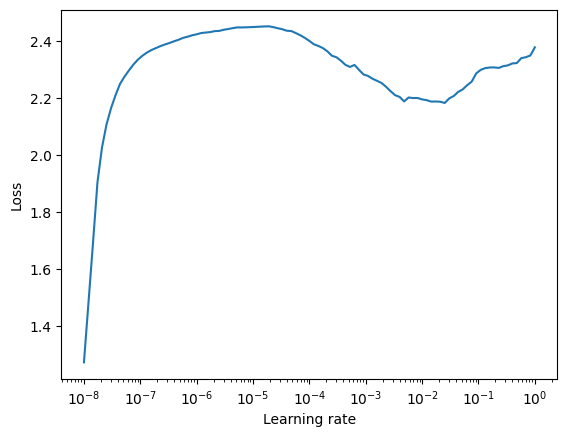

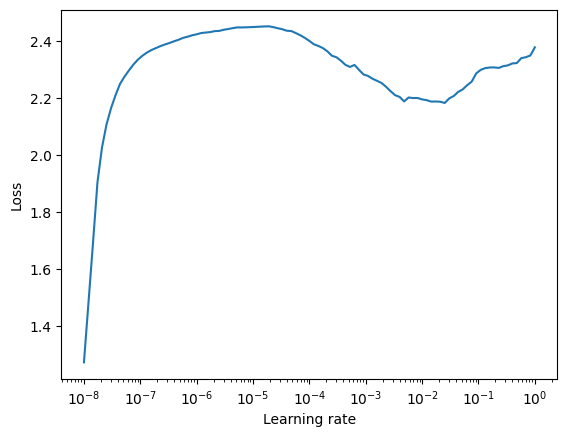

In [76]:
model = LResNet(resnet18, 3e-4) # will be overriden
trainer = pl.Trainer(max_epochs=10, check_val_every_n_epoch=5, log_every_n_steps=1)
tuner = pl.tuner.Tuner(trainer)
results = tuner.lr_find(model, train_loader)
results.plot()

From the graph, I'lll chose the starting value to be 1e-5 and the peak value to be 2e-3.

In [15]:
class LResNet(pl.LightningModule):
    def __init__(self, resnet_cls, max_lr, min_lr):
        super().__init__()
        self.resnet = resnet_cls()
        self.resnet.fc = nn.Linear(512, 10)
        self.max_lr = max_lr
        self.min_lr = min_lr
        
        self.accuracy = torchmetrics.Accuracy("multiclass", num_classes=10)

        self.img_scale = v2.ToDtype(torch.float32, scale=True)
        self.img_norm = v2.Normalize([0.48, 0.44, 0.40], [0.22, 0.22, 0.22])
        self.img_aug = v2.AutoAugment(v2.AutoAugmentPolicy.CIFAR10)

    def training_step(self, batch, batch_idx):
        X, y = batch
        X = self.img_norm(self.img_scale(self.img_aug(X)))
        y_pred = self.resnet(X)
        loss = nn.functional.cross_entropy(y_pred, y)
        self.log("train_loss", loss)
        acc = self.accuracy(y_pred, y)
        self.log("train_acc", acc)

        return loss

    def validation_step(self, batch, batch_idx):
        X, y = batch
        X = self.img_norm(self.img_scale(X))
        y_pred = self.resnet(X)
        loss = nn.functional.cross_entropy(y_pred, y)
        self.log("val_loss", loss)
        acc = self.accuracy(y_pred, y)
        self.log("val_acc", acc)

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.resnet.parameters(), lr=self.min_lr)
        scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=self.max_lr, epochs=30, steps_per_epoch=len(train_loader), div_factor=self.max_lr/self.min_lr)
        return [optimizer], [{"scheduler": scheduler, "interval": "step"}]

After testing and research, its probably best that we increase the max_epochs to something like 30 - it's a lot faster than the original one anyways. Running the below cell takes like less than 5 minutes while 10 epochs of the one above is also roughly similar.

In [33]:
model = LResNet(resnet18, 2e-3, 1e-5)
trainer = pl.Trainer(max_epochs=30, check_val_every_n_epoch=30, log_every_n_steps=1) 
trainer.fit(model, train_loader, test_loader)

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type               | Params | Mode 
--------------------------------------------------------
0 | resnet   | ResNet             | 11.2 M | train
1 | accuracy | MulticlassAccuracy | 0      | train
2 | img_norm | Normalize          | 0      | train
3 | img_aug  | AutoAugment        | 0      | train
--------------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.727    Total estimated model params size (MB)
71        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.


In [34]:
trainer.validate(model, test_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │     0.723800003528595     │
│         val_loss          │    0.8001051545143127     │
└───────────────────────────┴───────────────────────────┘

[{'val_loss': 0.8001051545143127, 'val_acc': 0.723800003528595}]

We're reaching the same performance as using smaller batches now! And it's still faster overall.

Next, we can just start with the biggest guns - using lower precision to train! The technical details are probably not helpful (using 16 bit in backward/forwards etc). The best is to use `bf16-mixed` if supported, which should speed up the process by a bit! However if it isn't available, `16-mixed` works too.

In [35]:
model = LResNet(resnet18, 2e-3, 1e-5)
trainer = pl.Trainer(precision="bf16-mixed", max_epochs=30, check_val_every_n_epoch=30, log_every_n_steps=1) 
trainer.fit(model, train_loader, test_loader)

Using bfloat16 Automatic Mixed Precision (AMP)
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type               | Params | Mode 
--------------------------------------------------------
0 | resnet   | ResNet             | 11.2 M | train
1 | accuracy | MulticlassAccuracy | 0      | train
2 | img_norm | Normalize          | 0      | train
3 | img_aug  | AutoAugment        | 0      | train
--------------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.727    Total estimated model params size (MB)
71        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.


In [36]:
trainer.validate(model, test_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.7163000106811523     │
│         val_loss          │    0.8184337615966797     │
└───────────────────────────┴───────────────────────────┘

[{'val_loss': 0.8184337615966797, 'val_acc': 0.7163000106811523}]

Accuracy suffers slightly due to reduced precision... but this argument matters a lot more with larger models (like transformers) so I'll keep it! 

Next, let's try using torch's optimization features to improve the speed of running the model.

In [42]:
torch.backends.cudnn.benchmark = True # this allows cuda to choose the fastest operations
model = LResNet(resnet18, 2e-3, 1e-5)
# model = torch.compile(model) # fuse everything to get a modest speedup. however, compile really, really hates random augmentations in the model, so i don't do this.

In [43]:
trainer = pl.Trainer(precision="bf16-mixed", max_epochs=30, check_val_every_n_epoch=30, log_every_n_steps=1) 
trainer.fit(model, train_loader, test_loader)

Using bfloat16 Automatic Mixed Precision (AMP)
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type               | Params | Mode 
--------------------------------------------------------
0 | resnet   | ResNet             | 11.2 M | train
1 | accuracy | MulticlassAccuracy | 0      | train
2 | img_norm | Normalize          | 0      | train
3 | img_aug  | AutoAugment        | 0      | train
--------------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.727    Total estimated model params size (MB)
71        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.


In [44]:
trainer.validate(model, test_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │     0.703000009059906     │
│         val_loss          │    0.8609970808029175     │
└───────────────────────────┴───────────────────────────┘

[{'val_loss': 0.8609970808029175, 'val_acc': 0.703000009059906}]

Wow, accuracy really tanking hard. I blame deterministic behaviour.  

Looking at the checklists, I realize this is basically all we can do for getting good speed - so let's just crank up the epochs one last time to see what the highest accuracy is! I'll give a deadline of maybe 15 minutes for training on this GPU (renting a 3060 right now) so we'll go for 100 epochs. I've also reduced the warmup epochs to 10% (instead of the default 30%) since we have the longer training schedule.  

I'll stopwatch the entire chunk of code from import to validation.

### The Final Code

In [1]:
import torch
import torch.nn as nn
import torchvision
from torchvision.models import resnet18
import pytorch_lightning as pl
import torchmetrics
from torchvision.transforms import v2

In [2]:
img_transforms = v2.Compose([
    v2.ToImage(),
])

train_ds = torchvision.datasets.CIFAR10(root="data", train=True, download=True, transform=img_transforms)
test_ds = torchvision.datasets.CIFAR10(root="data", train=False, download=True, transform=img_transforms)

train_loader = torch.utils.data.DataLoader(train_ds, batch_size=4096, shuffle=True, num_workers=3, pin_memory=True, prefetch_factor=2, persistent_workers=True)
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=4096, shuffle=False, num_workers=3, pin_memory=True, prefetch_factor=2, persistent_workers=True)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
torch.set_float32_matmul_precision('high')
torch.backends.cudnn.benchmark = True

In [4]:
class LResNet(pl.LightningModule):
    def __init__(self, resnet_cls, max_lr, min_lr):
        super().__init__()
        self.resnet = resnet_cls()
        self.resnet.fc = nn.Linear(512, 10)
        self.max_lr = max_lr
        self.min_lr = min_lr
        
        self.accuracy = torchmetrics.Accuracy("multiclass", num_classes=10)

        self.img_scale = v2.ToDtype(torch.float32, scale=True)
        self.img_norm = v2.Normalize([0.48, 0.44, 0.40], [0.22, 0.22, 0.22])
        self.img_aug = v2.AutoAugment(v2.AutoAugmentPolicy.CIFAR10)

    def training_step(self, batch, batch_idx):
        X, y = batch
        X = self.img_norm(self.img_scale(self.img_aug(X)))
        y_pred = self.resnet(X)
        loss = nn.functional.cross_entropy(y_pred, y)
        self.log("train_loss", loss)
        acc = self.accuracy(y_pred, y)
        self.log("train_acc", acc)

        return loss

    def validation_step(self, batch, batch_idx):
        X, y = batch
        X = self.img_norm(self.img_scale(X))
        y_pred = self.resnet(X)
        loss = nn.functional.cross_entropy(y_pred, y)
        self.log("val_loss", loss)
        acc = self.accuracy(y_pred, y)
        self.log("val_acc", acc)

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.resnet.parameters(), lr=self.min_lr)
        scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=self.max_lr, epochs=100, steps_per_epoch=len(train_loader), div_factor=self.max_lr/self.min_lr, pct_start=0.1)
        return [optimizer], [{"scheduler": scheduler, "interval": "step"}]

In [5]:
model = LResNet(resnet18, 2e-3, 1e-5)
trainer = pl.Trainer(precision="bf16-mixed", max_epochs=100, check_val_every_n_epoch=25, log_every_n_steps=5) 
trainer.fit(model, train_loader, test_loader)

Using bfloat16 Automatic Mixed Precision (AMP)
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type               | Params | Mode 
---------------------------------------------------------
0 | resnet    | ResNet             | 11.2 M | train
1 | accuracy  | MulticlassAccuracy | 0      | train
2 | img_scale | ToDtype            | 0      | train
3 | img_norm  | Normalize          | 0      | train
4 | img_aug   | AutoAugment        | 0      | train
---------------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.727    Total estimated model params size (MB)
72        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


In [6]:
trainer.validate(model, test_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.7807999849319458     │
│         val_loss          │    0.7300027012825012     │
└───────────────────────────┴───────────────────────────┘

[{'val_loss': 0.7300027012825012, 'val_acc': 0.7807999849319458}]

Okay I actually missed the thing ending :( but I stopped the clock at 6 mins so overall this is still hella fast!!!

In [8]:
torch.save(model.resnet.state_dict(), "model.pth")